In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats,optimize 
import pandas as pd

%matplotlib inline

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

-1.8977435561331
     fun: 9397.454430490903
    nfev: 26
     nit: 21
 success: True
       x: -1.8977435561331


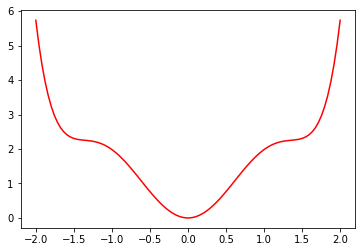

In [5]:
def six_hump(x,y):
    return (4-2.1*x**2 + x**4/3)*x**2+x*y+(4*y**2-4)*y**2

x=np.linspace(-2,2, 100)
y=np.linspace(-1,1,100)


plt.plot(x, six_hump(x, y), 'r')
from scipy.optimize import brentq
sol = optimize.minimize_scalar(six_hump, args=(7,))
print(sol['x'])
print(sol)

                        fun: 2393.204768472884
 lowest_optimization_result:       fun: 2393.204768472884
 hess_inv: array([[0.02517147]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([-1.85117171])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1674
                        nit: 100
                       njev: 837
                          x: array([-1.85117171])


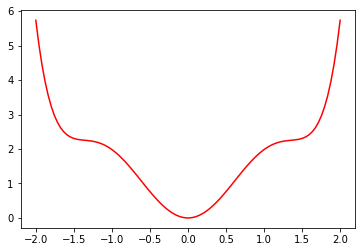

In [6]:
from scipy.optimize import basinhopping

plt.plot(x, six_hump(x, y), 'r')


x0 = 0
solution = basinhopping(six_hump, x0, stepsize=1, minimizer_kwargs={'args': (5,)}) # see how the parameters are passed to the function
print(solution)

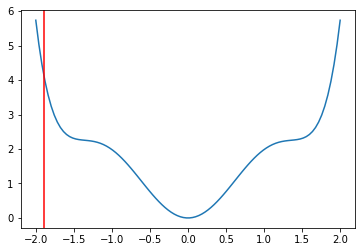

In [8]:
plt.plot(x, six_hump(x, y))
plt.axvline(sol['x'], color='r')

In [9]:
from scipy.optimize import basinhopping

x0 = -10
solution = basinhopping(six_hump, x0, stepsize=1, minimizer_kwargs={'args': (8,)}) # see how the parameters are passed to the function
print(solution)

                        fun: 16115.54630956303
 lowest_optimization_result:       fun: 16115.54630956303
 hess_inv: array([[0.02091172]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-1.91823742])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1702
                        nit: 100
                       njev: 851
                          x: array([-1.91823742])


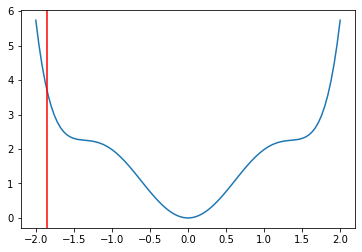

In [41]:
plt.plot(x, six_hump(x, y))
plt.axvline(solution['x'], color='r')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

The Maximum and Minimum are as follows  (2.0, -2.0, 1.0, -1.0)


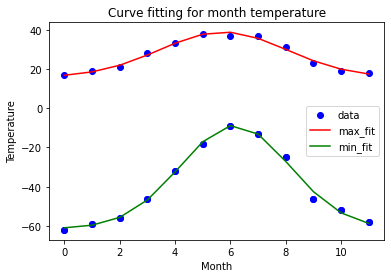

In [10]:
from scipy.optimize import curve_fit

max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

# finding maximun and minimum value

def max_min(max_temp,min_temp):
    
    x_max,x_min,y_max,y_min = np.max(x),np.min(x), np.max(y),np.min(y)
    return x_max, x_min, y_max,  y_min
print("The Maximum and Minimum are as follows ",max_min(max_temp,min_temp))



x = np.arange(12)
# fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(x=x, y=y, marker='o', c='r', label="data")

# plt.plot(x,max_temp,  'ro')
plt.plot(x,min_temp,'bo')

def gaus(x,a,x0,sigma,d):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+d

popt,pcov = curve_fit(gaus,x,max_temp)
popt2,pcov2 = curve_fit(gaus,x,min_temp,p0 = [60, 6, 6, -62])


plt.plot(x,max_temp,'bo',label='data')
plt.plot(x,gaus(x,*popt),'r',label='max_fit')


plt.plot(x,min_temp,'bo')
plt.plot(x,gaus(x,*popt2),'g',label='min_fit')





plt.legend()
plt.title('Curve fitting for month temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.show()

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

chi2 : 4195.997739335573
P-value : 0.0


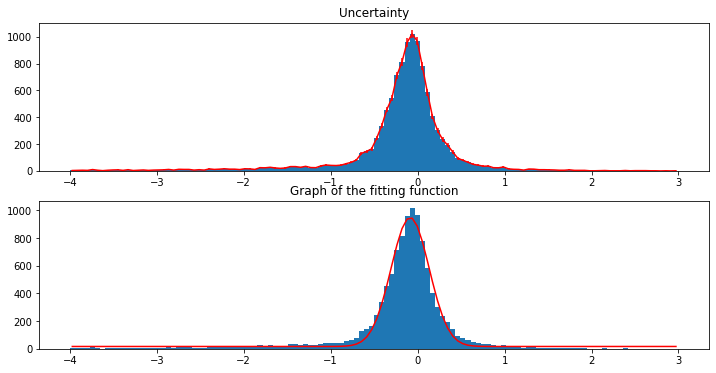

In [12]:
# !type data\residuals_261.pkl 

df= pd.read_pickle("data/residuals_261.pkl")
df= pd.DataFrame(df.item())
residual= df['residuals']
residual=np.array(residual)
# print(residual)

distance=df['distances']
distance=np.array(distance)



fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(12, 6)) 
h, bins, _ = ax1.hist(residual, bins=120, range=(-4, 3))
bi = (bins[:-1] + bins[1:])/2. # finding bi- Center 

# print(bi.shape())
sig_i=np.sqrt(np.abs(h))

# print(len(h))

ax1.set_title("Uncertainty")
ax1.errorbar(x = bi, y = h, yerr = sig_i, color = 'red')
# xmin,xmax = plt.xlim()

h2, bins2, _ = ax2.hist(residual, bins=120, range=(-4, 3))
# mu, std = stats.norm.fit(residual)
std=np.std(residual)
mean=np.mean(residual)


popt,pcov = optimize.curve_fit(gaus,bi, h, p0 = [ max(residual),mean,std,0]) #also setting starting point

ax2.set_title("Graph of the fitting function")
# ax2.hist(residual,bins = 120, range = (-4,4))
ax2.plot(bi, gaus(bi, *popt), color ='red')



#Checking Goodness of fit

op = tuple(popt)
g_fit = gaus(bi, *popt)
ndof = len(bi) - 1 
cov = np.cov(bi, h, ddof=2)
b_hat = cov[0,1] / cov[0,0]
a_hat = np.mean(h - b_hat*bi)
chi2 = np.sum(((h - g_fit)**2) / std**2)
print("chi2 :", chi2)
Pval = 1. - stats.chi2.cdf(chi2, ndof)
print("P-value :", Pval)



4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

The Average Temperature in Munich is :  9.384097734976043


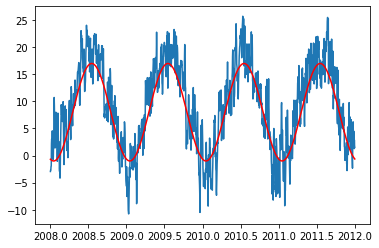

Answer: The value 'b' is acting to be considering the initial value for cos funtion and it is actually the phase of the function, with the change in the 'b' the function change its phase 

The best fit value of Parameters are  a=-9  b=6   c=8 

The Min and Max value prdicted py Predicter are
 Max : 16.99998973805892 Min : -0.9997178068813888


In [13]:
def funfit(t,a,b,c):
    return a*np.cos(2*np.pi*t+b)+c

df=pd.read_csv("data/munich_temperatures_average_with_bad_data.txt", sep=" ", header=None)
df.columns=['years','temp']

dfplot= df[(df['years']>=2008) & (df['years']<=2012)]

temp= dfplot['temp'].to_numpy()
avg_temp= np.mean(temp)


# setting noise to avg value
temp[temp>=60]=avg_temp
# print(temp1)
print("The Average Temperature in Munich is : ",avg_temp)

a,b,c=-9,6,8

t = dfplot['years'].to_numpy()
y=[funfit(t[i],a,b,c) for i in range(len(t))]
plt.plot(t,temp, label="Temperature")
plt.plot(t,y,'r', label="Fitting Function")# fitting value
plt.show()

print("Answer: The value 'b' is acting to be considering the initial value for cos funtion and it is actually the phase of the function, with the change in the 'b' the function change its phase ")
print("\nThe best fit value of Parameters are  a=-9  b=6   c=8 ")

print("\nThe Min and Max value prdicted py Predicter are\n Max :",np.max(y),"Min :",np.min(y))



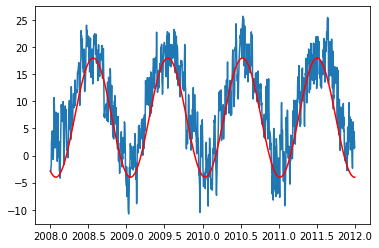

fssr results  21834.35282687009
gssr  29923.359370625574
CL: 1.000 , additional parameter necessary: NO


1.0

In [15]:
def g(t,a,b,c,d):
    return a*np.cos(2*np.pi*b*t+c)+d

a,b,c,d=-11,1.02,4.8,7

y2=[g(t[i],a,b,c,d) for i in range(len(t))]
plt.plot(t,temp, label="Temperature")
plt.plot(t,y2,'r', label="Fitting Function")# fitting value
plt.show()



fssr = 0
gssr = 0
for i in range(len(t)-1):
    fssr = fssr + (temp[i] - y[i])**2
    gssr = gssr + (temp[i] - y2[i])**2

print("fssr results ", fssr)
print("gssr ", gssr)




# Fisher test

from scipy.stats import f

### function from lecture 08
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=True):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL 

Ftest(fssr, gssr, 3,4, len(x))

